# Install Some Packages

In [76]:
!pip install rasterio
!pip install earthpy
!pip install tensorflow

# Import Packages

In [77]:
import pandas as pd
import numpy as np
import rasterio
import earthpy.plot as ep
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
from matplotlib.colors import from_levels_and_colors
from tensorflow.keras.layers import Dense, Input, Flatten, Conv1D
from tensorflow.keras.models import Model
import numpy as np
from tensorflow.keras import Model
from tensorflow.keras.callbacks import EarlyStopping

# Mount Google Drive

In [75]:
#Only run this code if you use Google Colab
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

# Parameter

In [78]:
FEATURES = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'EVI', 'NBR', 'NDMI', 'NDWI', 'NDBI', 'NDBaI', 'elevation']
LABEL = ['classvalue']
SPLIT = ['sample']
N_CLASSES = 6
CLASSES = [1, 2, 3, 4, 5, 6]
PALETTE = ['#F08080', '#D2B48C', '#87CEFA', '#008080', '#90EE90', '#228B22']

In [79]:
#if you execute in local run this code
SAMPLE_PATH = 'Samples_Primavera.csv'
IMAGE_PATH = 'Primavera.tif'

In [ ]:
#if you execute in Google Colab run this code
SAMPLE_PATH = '/content/drive/MyDrive/deep/Samples_Primavera.csv'
IMAGE_PATH = '/content/drive/MyDrive/deep/Primavera.tif'

# Load image

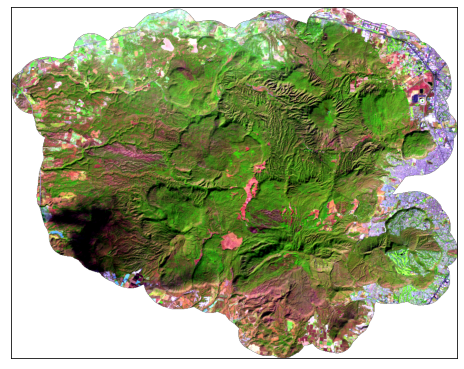

<AxesSubplot:>

In [80]:
image = rasterio.open(IMAGE_PATH)
bandNum = image.count
height = image.height
width = image.width
crs = image.crs
transform = image.transform
shape = (height, width)

image_vis = []
for x in [6, 5, 4]:
  image_vis.append(image.read(x))
image_vis = np.stack(image_vis)

plot_size = (8, 8)
ep.plot_rgb(
  image_vis,
  figsize=plot_size,
  stretch=True,
)

# Read sample

In [81]:
samples = pd.read_csv(SAMPLE_PATH)
samples = samples.sample(frac = 1) # Shuffle data
samples

,B1,B2,B3,B4,B5,B6,B7,EVI,NBR,NDMI,NDWI,NDBI,NDBaI,elevation,classvalue,sample
1770,0.045657,0.048985,0.065100,0.073157,0.204662,0.214232,0.144107,0.257606,0.173624,-0.022846,-0.517353,0.022846,0.195694,1755,1,train
2713,0.011090,0.012135,0.018102,0.015187,0.058390,0.036445,0.020605,0.102037,0.478321,0.231402,-0.526686,-0.231402,0.277651,1952,1,test
955,0.027095,0.038837,0.063422,0.063092,0.239120,0.196632,0.115095,0.331778,0.350140,0.097504,-0.580737,-0.097504,0.261567,1598,1,train
6497,0.029927,0.039937,0.062377,0.072690,0.243328,0.222565,0.142760,0.309140,0.260479,0.044565,-0.591911,-0.044565,0.218449,1574,5,train
5504,0.064908,0.087072,0.114105,0.146087,0.221465,0.223362,0.183048,0.130416,0.094972,-0.004266,-0.319933,0.004266,0.099198,1715,3,test
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
524,0.022970,0.025060,0.037710,0.031935,0.190390,0.121832,0.058115,0.331760,0.532283,0.219579,-0.669356,-0.219579,0.354089,1895,1,train
6183,0.082342,0.088145,0.147902,0.147462,0.312022,0.218577,0.156455,0.267889,0.332070,0.176112,-0.356841,-0.176112,0.165646,1490,4,train
40,0.027150,0.028882,0.040075,0.036912,0.170205,0.143145,0.078272,0.283586,0.369983,0.086357,-0.618842,-0.086357,0.292987,1919,1,train
5301,0.082617,0.104233,0.155355,0.182387,0.258425,0.278995,0.256115,0.121001,0.004489,-0.038275,-0.249094,0.038275,0.042758,1732,3,test


# Split into train and test based on column

In [82]:
train = samples[samples['sample'] == 'train']
test = samples[samples['sample'] == 'test']

# Split between features and label

In [83]:
train_features = train[FEATURES]
train_label = train[LABEL]
test_features = test[FEATURES]
test_label = test[LABEL]

# Function to reshape array input

In [84]:
def reshape_input(array):
  shape = array.shape
  return array.reshape(shape[0], shape[1], 1)

# Convert samples dataframe (pandas) to numpy array

In [ ]:
train_input = reshape_input(train_features.to_numpy())
test_input = reshape_input(test_features.to_numpy())

# Also make label data to categorical

In [ ]:
train_output = to_categorical(train_label.to_numpy(), N_CLASSES + 1, int)
test_output = to_categorical(test_label.to_numpy(), N_CLASSES + 1, int)

# Show the data shape


In [ ]:
print(f'Train features: {train_input.shape}\nTest features: {test_input.shape}\nTrain label: {train_output.shape}\nTest label: {test_output.shape}')

Train features: (4968, 14, 1)
Test features: (2714, 14, 1)
Train label: (4968, 7)
Test label: (2714, 7)


# Make model for our data

# Input shape

In [ ]:
train_shape = train_input.shape
input_shape = (train_shape[1], train_shape[2])


# Make model

In [ ]:
inputs = Input(shape = input_shape, name = "clasificator_input")

In [ ]:
x = Conv1D(64, 2, activation = "relu")(inputs)
x = Conv1D(64, 2, activation = "relu", strides = 2, padding = "same")(x)
x = Conv1D(128, 2, activation = "relu")(x)
x = Conv1D(128, 2, activation = "relu", strides = 3, padding = "same")(x)
x = Conv1D(128, 2, activation = "relu", strides = 2, padding = "same")(x)
x = Flatten()(x)
x = Dense(128, activation = "relu" )(x)
x = Dense(64, activation = "relu" )(x)
clasificate = Dense(N_CLASSES + 1, activation = 'softmax')(x)

clasificator = Model(inputs, clasificate, name='clasificator')
clasificator.summary()

Model: "clasificator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 clasificator_input (InputLa  [(None, 14, 1)]          0         
 yer)                                                            
                                                                 
 conv1d_5 (Conv1D)           (None, 13, 64)            192       
                                                                 
 conv1d_6 (Conv1D)           (None, 7, 64)             8256      
                                                                 
 conv1d_7 (Conv1D)           (None, 6, 128)            16512     
                                                                 
 conv1d_8 (Conv1D)           (None, 2, 128)            32896     
                                                                 
 conv1d_9 (Conv1D)           (None, 1, 128)            32896     
                                                      

In [ ]:
outputs = clasificator(inputs)
model = Model(inputs, outputs, name='clasificator')

# Train the model

# Compline the model

In [ ]:
model.compile(
    optimizer='Adam',
    loss='CategoricalCrossentropy',
    metrics=['accuracy']
)

# Create callback to stop training if loss not decreasing

In [ ]:
stop = EarlyStopping(
    monitor='loss',
    patience=5
)


# Fit the model

In [ ]:
result = model.fit(
    x=train_input, y=train_output,
    validation_data=(test_input, test_output),
    batch_size=1024,
    callbacks=[stop],
    epochs=100,
)

Epoch 1/100


5/5 [==============================] - 1s 83ms/step - loss: 1.9307 - accuracy: 0.4126 - val_loss: 1.9105 - val_accuracy: 0.1909
Epoch 2/100
5/5 [==============================] - 0s 39ms/step - loss: 1.8426 - accuracy: 0.5177 - val_loss: 1.8197 - val_accuracy: 0.1909
Epoch 3/100
5/5 [==============================] - 0s 36ms/step - loss: 1.5873 - accuracy: 0.5177 - val_loss: 1.8245 - val_accuracy: 0.1909
Epoch 4/100
5/5 [==============================] - 0s 36ms/step - loss: 1.4080 - accuracy: 0.5177 - val_loss: 1.6397 - val_accuracy: 0.1909
Epoch 5/100
5/5 [==============================] - 0s 42ms/step - loss: 1.2825 - accuracy: 0.5177 - val_loss: 1.6099 - val_accuracy: 0.1993
Epoch 6/100
5/5 [==============================] - 0s 37ms/step - loss: 1.1611 - accuracy: 0.5252 - val_loss: 1.4670 - val_accuracy: 0.5221
Epoch 7/100
5/5 [==============================] - 0s 47ms/step - loss: 1.0351 - accuracy: 0.6465 - val_loss: 1.3474 - val_accuracy: 0.6124
Epoch 8/100
5/5 [===============

# Show history

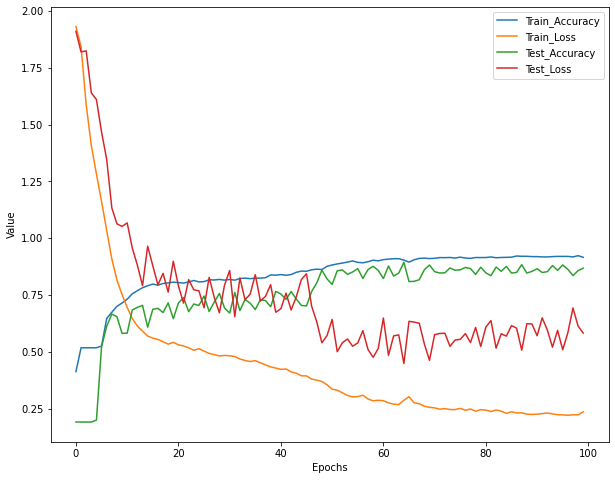

In [ ]:
history = pd.DataFrame(result.history)

plt.figure(figsize = (10, 8))
plt.plot(range(len(history['accuracy'].values.tolist())), history['accuracy'].values.tolist(), label = 'Train_Accuracy')
plt.plot(range(len(history['loss'].values.tolist())), history['loss'].values.tolist(), label = 'Train_Loss')
plt.plot(range(len(history['val_accuracy'].values.tolist())), history['val_accuracy'].values.tolist(), label = 'Test_Accuracy')
plt.plot(range(len(history['val_loss'].values.tolist())), history['val_loss'].values.tolist(), label = 'Test_Loss')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()
plt.show()

# Predict test data

In [ ]:
prediction = np.argmax(model.predict(test_input), 1).flatten()
label = np.argmax(test_output, 1).flatten()

# Confusion matrix

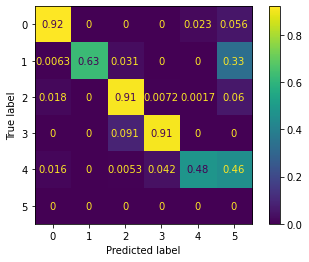

In [ ]:
cm = confusion_matrix(label, prediction, normalize='true')
cm = ConfusionMatrixDisplay(cm)
cm.plot()


# Classification report

In [ ]:
print(classification_report(label, prediction))

              precision    recall  f1-score   support

           1       0.93      0.92      0.92       518
           2       1.00      0.63      0.77       159
           3       0.99      0.91      0.95      1815
           4       0.59      0.91      0.71        33
           5       0.86      0.48      0.62       189
           6       0.00      0.00      0.00         0

    accuracy                           0.87      2714
   macro avg       0.73      0.64      0.66      2714
weighted avg       0.97      0.87      0.91      2714



c:\Users\Cesar\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Cesar\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Cesar\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Predict image using the model

In [ ]:
image_input = []
for x in range(14):
  image_input.append(image.read(x + 1))
image_input = reshape_input(np.stack(image_input).reshape(14, -1).T)

# Predict

In [ ]:
prediction = model.predict(image_input, batch_size=4096*20)
prediction = np.argmax(prediction, 1)
prediction = prediction.reshape(shape[0], shape[1])

# Visualize

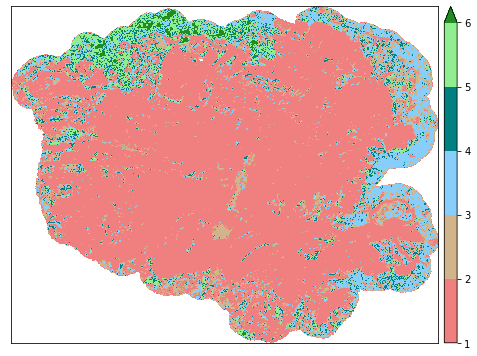

<AxesSubplot:>

In [ ]:
cmap, norm = from_levels_and_colors(CLASSES, PALETTE, extend='max')
ep.plot_bands(prediction, cmap=cmap, norm=norm, figsize=plot_size)

# Save file in local

In [ ]:
#if you execute in local run this code
name = 'deepPrimavera.tif'
location = name

# Save file in Google Drive

In [ ]:
#Only run this code if you use Google Colab
save_location = '/content/drive/MyDrive/Deep/'
name = 'deepPrimavera.tif'
location = save_location + name

In [85]:
new_dataset = rasterio.open(
      location,
      mode='w', driver='GTiff',
      height = prediction.shape[0], width = prediction.shape[1],
      count=1, dtype=str(prediction.dtype),
      crs=crs,
      transform=transform
)
new_dataset.write(prediction, 1);
new_dataset.close()

RasterioIOError: Attempt to create new tiff file '/content/drive/MyDrive/Deep/deepPrimavera.tif' failed: No error